### Data Preprocessing

In [100]:
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim

In [102]:
example_sentence = """In the case of CBOW, one word is eliminated, and the word is predicted from surrounding words.
Therefore, it takes multiple input vectors as inputs to the model and creates one output vector.
In contrast, Skip-Gram learns by removing all words except one word and predicting the surrounding words in the context through one word. 
So, it takes a vector as input and produces multiple output vectors.
CBOW and Skip-Gram are different."""

In [104]:
# 문장 내 구두점 제거 및 대문자->소문자 변환
sentence = example_sentence.lower()
sentence = re.sub(r'[^a-z0-9]+', ' ', sentence)

# 단어 토큰화 수행
tokens = word_tokenize(sentence)

In [106]:
vocab = Counter(tokens)
word2idx = {word: idx for idx, (word, _) in enumerate(vocab.items())}
idx2word = {idx: word for word, idx in word2idx.items()}
vocab_size = len(word2idx)
vocab_size

43

In [110]:
# CBOW dataset 생성
def generate_cbow_data(tokens, window_size):
    data = []
    # 입력 데이터 내 단어가 vacab에 포함되어 있으면 해당 단어의 idx 추출
    indices = [word2idx[word] for word in tokens]
    for i in range(window_size, len(indices) - window_size):
        # CBOW는 주변 단어(context)을 바탕으로 중심 단어(target)을 예측함
        context = indices[i - window_size:i] + indices[i + 1:i + 1 + window_size] # 중심단어(i) 앞 단어 + 중심단어(i) 뒤 단어 
        target = indices[i]
        data.append((context, target))
    return data

cbow_data = generate_cbow_data(tokens, 2)


# skip-gram
def generate_skipgram_data(corpus, window_size):
    data = []
    indices = [word2idx[word] for word in sentence if word in word2idx]
    for i in range(len(indices)):
        for j in range(-window_size, window_size + 1): # indices 리스트에서 가져온 현재 단어 기준으로 좌우 window size 범위 내 단어 확인
            if j != 0 and 0 <= i + j < len(indices):  # 현재 단어를 제외하고 좌우 단어가 인덱스 범위를 벗어나지 않는 경우만 처리함
                data.append((indices[i], indices[i + j]))  # (target, context) 쌍
    return data

skipgrap_data = generate_skipgram_data(tokens, 2)

### CBOW

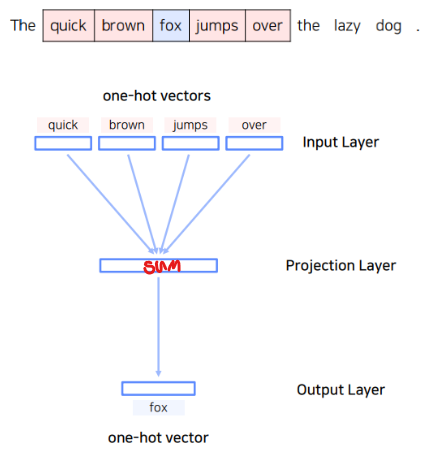

In [113]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(CBOW, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, context):
        x = self.embedding(context)
        x = self.linear(x.mean(dim=1))
        return x    

### Skip-Gram

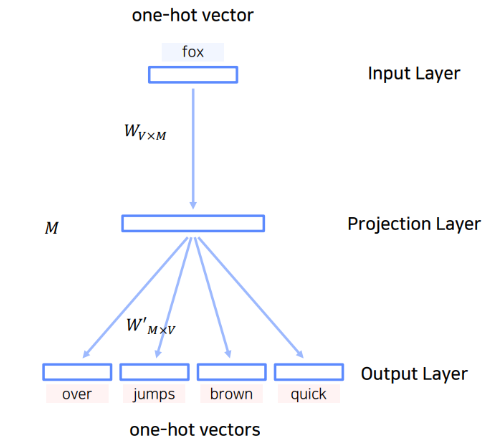

In [130]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGram, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, target):
        x = self.embedding(target)
        x = self.linear(x)
        return x

In [132]:
# hyperparameter
embedding_dim = 10
loss_fn = nn.CrossEntropyLoss()
lr = 0.01

# model train
def train(model, data, epochs=10, lr=lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        
        for context, target in data:
            context_tensor = torch.tensor(context, dtype=torch.long).unsqueeze(0)
            target_tensor = torch.tensor([target], dtype=torch.long)
            
            optimizer.zero_grad()
            output = model(context_tensor)
            
            loss = loss_fn(output, target_tensor)
            loss.backward()

            optimizer.step()
            total_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            correct += (pred == target_tensor).sum().item()
            total += target_tensor.size(0)
        acc = correct / total

        print(f'Epoch {epoch+1}, loss: {total_loss:.4f}, acc: {acc:.4f}')

In [134]:
cbow_model = CBOW(vocab_size, embedding_dim)
print("Training CBOW Model...")
train(cbow_model, cbow_data)

Training CBOW Model...
Epoch 1, loss: 265.8733, acc: 0.0571
Epoch 2, loss: 235.7539, acc: 0.1571
Epoch 3, loss: 214.5405, acc: 0.2571
Epoch 4, loss: 193.9896, acc: 0.3429
Epoch 5, loss: 173.6476, acc: 0.4143
Epoch 6, loss: 153.6436, acc: 0.5143
Epoch 7, loss: 134.4321, acc: 0.5857
Epoch 8, loss: 116.4707, acc: 0.6714
Epoch 9, loss: 99.9772, acc: 0.7286
Epoch 10, loss: 85.0664, acc: 0.8143


In [136]:
skipgram_model = SkipGram(vocab_size, embedding_dim)
print("Training CBOW Model...")
train(skipgram_model, skipgrap_data)

Training CBOW Model...
Epoch 1, loss: 48.7056, acc: 0.9286
Epoch 2, loss: 0.5030, acc: 1.0000
Epoch 3, loss: 0.2551, acc: 1.0000
Epoch 4, loss: 0.1560, acc: 1.0000
Epoch 5, loss: 0.1057, acc: 1.0000
Epoch 6, loss: 0.0766, acc: 1.0000
Epoch 7, loss: 0.0582, acc: 1.0000
Epoch 8, loss: 0.0458, acc: 1.0000
Epoch 9, loss: 0.0370, acc: 1.0000
Epoch 10, loss: 0.0306, acc: 1.0000
